<a href="https://colab.research.google.com/github/gordoncd/ReefNet/blob/main/UNet_w_kmeans_labelsl8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Google Colaboratory Implementation of UNet for Atoll Segmentation

Authors: Gordon Doore, Drew Hinton, Sameer Khan

code adapted from:

## Import basic libraries

In [1]:
#imports and dependencies
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Let's define our model:

In [2]:
#let's set up the structure of our model:
def multi_unet_model(n_classes=3, IMG_HEIGHT=448, IMG_WIDTH=448, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   #Normalize images before input

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    print(c4.shape)
    c4 = Dropout(0.2)(c4)
    print(c4.shape)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    print(c4.shape)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model#, c9 to get features

## Now we load data

mount drive

In [3]:
#mount drive and set up directories

from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


make sizes match desired input from model

In [4]:
#Resizing images, if needed
SIZE_X = 224
SIZE_Y = 224
n_classes=3 #Number of classes for segmentation


In [5]:

#rounding to be utilized later
def custom_round(x, base=5):
    return int(base * round(float(x)/base))


In [7]:
#Capture mask/label info as a list


train_masks = []
train_images = []
#need to sort and make list of names
# then match to training images
#then save masks and training images to matching indexes of image and ground truth arrs
mask_path = "/content/drive/MyDrive/CR_meta/JPG_Labeled/"
im_path = "/content/drive/MyDrive/CR_meta/NIR/"

#sort masks by name
maskDisO = os.listdir(mask_path)
maskNames = sorted(maskDisO)
#sort imgs by name
imDisO = os.listdir(im_path)
imNames = sorted(imDisO)
#now need to do name matching
#will take a mask, and check if imNames has any files with corresponding names
#if it does contain a match, save mask to train_masks, and image to train_images


for mask in maskNames:
  for im in imNames:
    if mask[:-6] in im and mask.endswith("l8.jpg"):#checks for substring
      maskArr = cv2.imread(mask_path+mask)
      imArr = cv2.imread(im_path+im)

      maskArr = cv2.resize(maskArr,(SIZE_X,SIZE_Y), interpolation = cv2.INTER_CUBIC)
      imArr = cv2.resize(imArr,(SIZE_X,SIZE_Y), interpolation = cv2.INTER_CUBIC)

      train_masks.append(maskArr)
      train_images.append(imArr)


#Convert list to array
train_masks = np.array(train_masks)
print(str(train_masks.shape)+"\n"+str(train_masks.size))
train_images = np.array(train_images)
print(str(train_images.shape)+"\n"+str(train_images.size))

normalRGBtrain = [] #mask images resized
RGBorig = [] #images resized
for imgIdx in range(train_images.shape[0]):
  img = train_images[imgIdx]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  rotate = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  twoRotate = cv2.rotate(rotate, cv2.ROTATE_90_CLOCKWISE)
  threeRotate = cv2.rotate(twoRotate, cv2.ROTATE_90_CLOCKWISE)

  RGBorig.append(img)
  RGBorig.append(rotate)
  RGBorig.append(twoRotate)
  RGBorig.append(threeRotate)


train_images = np.array(RGBorig)

for imgIdx in range(train_masks.shape[0]):
  img = cv2.cvtColor(train_masks[imgIdx], cv2.COLOR_BGR2GRAY)
  ret,ocean = cv2.threshold(img,50,255,cv2.THRESH_BINARY_INV)
  ret,reef = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
  ret,reefLand = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
  land = reefLand - reef
  label = []
  label.append(reef)
  label.append(land)
  label.append(ocean)
  label = np.array(label)
  label = np.swapaxes(label, 0,1)
  label = np.swapaxes(label, 1,2)
  plt.show()
  label = label/255
  rotate = cv2.rotate(label, cv2.ROTATE_90_CLOCKWISE)
  maskTwoRotate = cv2.rotate(rotate, cv2.ROTATE_90_CLOCKWISE)
  maskThreeRotate = cv2.rotate(maskTwoRotate, cv2.ROTATE_90_CLOCKWISE)
  #append in same order as above so indices correspond to a mask, image pair
  normalRGBtrain.append(label)
  normalRGBtrain.append(rotate)
  normalRGBtrain.append(maskTwoRotate)
  normalRGBtrain.append(maskThreeRotate)



train_masks = np.array(normalRGBtrain)

print(train_masks.shape)
print(train_images.shape)

(145, 224, 224, 3)
21826560
(145, 224, 224, 3)
21826560
(580, 224, 224, 3)
(580, 224, 224, 3)


split data

In [8]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

#here need to split data and order in a way that makes index in array correspond to particular image-mask pair
X1, X_test, y1, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 0)

#Further split training data t0 a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

from keras.utils import to_categorical

## Model training

In [9]:
##prep eval metrics

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [10]:
###############################################################
from sklearn.utils import class_weight
# print(np.unique(train_masks))
# class_weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                         classes = (0,1,2),
#                                         y = train_masks   )
# print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])
model.summary()

#If starting with pre-trained weights.
#model.load_weights('/content/drive/MyDrive/Coral_Reef_Metadata/aiZoom-atolls-w-kmeans-8.hdf5')

history = model.fit(X_train, y_train,
                    batch_size = 4,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    #class_weight=class_weights,
                    shuffle=False)



model.save('/content/drive/MyDrive/CR_meta/aiZoom-atolls-w-kmeans-8.hdf5')

(None, 28, 28, 128)
(None, 28, 28, 128)
(None, 28, 28, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                  

## Model evaluation

accuracy

In [11]:
#Evaluate the model
	# evaluate model
%time
print(model.evaluate(X_test, y_test))
_, f1 = model.evaluate(X_test, y_test)
print("F1 is = ", (f1 * 100.0), "%")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 14.3 µs
2/2 [==============================] - 4s 2s/step - loss: 0.0521 - f1_m: 0.9788
[0.05212727189064026, 0.9787907004356384]
2/2 [==============================] - 0s 57ms/step - loss: 0.0521 - f1_m: 0.9788
F1 is =  97.87907004356384 %


 IoU

In [12]:
##################################
#model = get_model()
model.load_weights('/content/drive/MyDrive/CR_meta/aiZoom-atolls-w-kmeans-8.hdf5')

#make prediction that we can look at later

y_pred=model.predict(X_test)
print(y_pred.shape)
y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape)

##################################################


2/2 [==============================] - 0s 44ms/step
(58, 224, 224, 3)
(58, 224, 224)


In [13]:
##################################################
#Using built in keras function to computer IoU
from keras.metrics import MeanIoU
n_classes = 3
testIndex = 3
IOU_keras = MeanIoU(num_classes=n_classes)
print(y_test[:,:,:,0].shape)
# print(y_pred_argmax[0,:,:].shape)
print(np.around(y_pred[:,:,:,0],decimals=0).shape)
iou1 = IOU_keras.update_state(y_test[:,:,:,0], np.around(y_pred[:,:,:,0],decimals=0))
print("vegetation IoU: " + str(IOU_keras.result().numpy()))
res1 = IOU_keras.result().numpy()

iou2 = IOU_keras.update_state(y_test[:,:,:,1], np.around(y_pred[:,:,:,1],decimals=0))
print("reef flat IoU: " + str(IOU_keras.result().numpy()))
res2 = IOU_keras.result().numpy()

iou3 = IOU_keras.update_state(y_test[:,:,:,2], np.around(y_pred[:,:,:,2],decimals=0))
print("ocean IoU: " + str(IOU_keras.result().numpy()))
res3 = IOU_keras.result().numpy()

print("Mean IoU: " + str((res1+res2+res3)/3))
#######################################################################

(58, 224, 224)
(58, 224, 224)
vegetation IoU: 0.93099624
reef flat IoU: 0.9126019
ocean IoU: 0.96924764
Mean IoU: 0.9376152356465658


F1 score

In [14]:
#evaluate other metric for accuracy
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

# evaluate the model f1, precision, recall
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
loss, accuracy, f1_score, precision, recall = model.evaluate(y_test, y_pred, verbose=0)
print(f1_score, ", ", precision, " , ", recall)

0.851125955581665 ,  0.8509002923965454  ,  0.8513519763946533


## Let's see performance on our test set

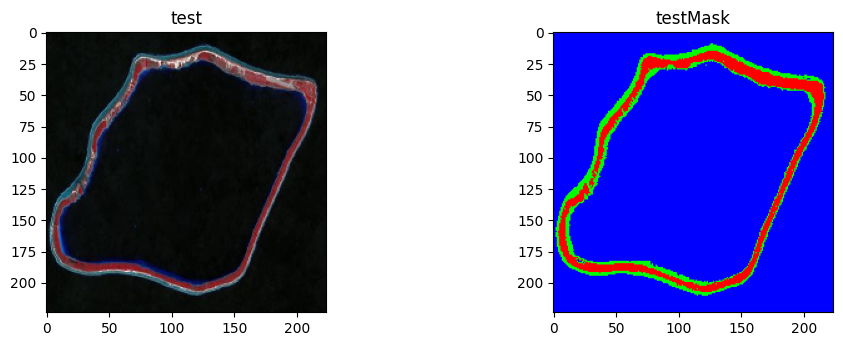

(224, 224, 3)
1/1 [==============================] - 0s 299ms/step


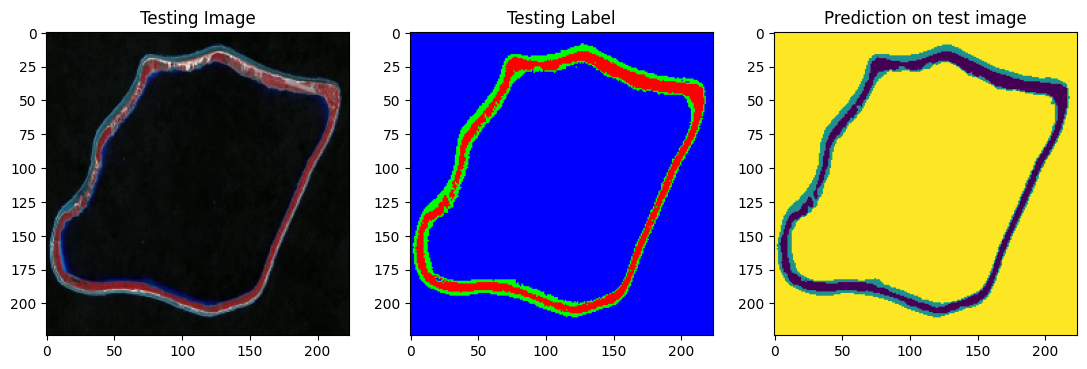

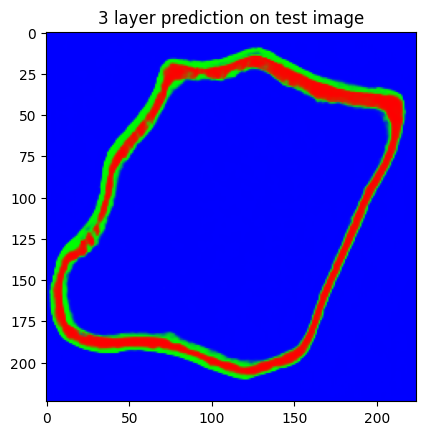

In [15]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
# print(test_img.shape)
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test = np.squeeze(test_img)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('test')
imgplot = plt.imshow(test,cmap='viridis')
plt.subplot(222)
plt.title('testMask')
imgplot = plt.imshow(255*np.squeeze(ground_truth),cmap='viridis')
plt.show()
print(test_img.shape)
four_dim = np.expand_dims(test_img, axis = 0)

prediction = (model.predict(four_dim))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(18, 20))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img, cmap='viridis')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(255*ground_truth, cmap='viridis')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='viridis')
plt.show()
plt.title('3 layer prediction on test image')
plt.imshow(prediction[0,:,:,:], cmap='viridis')
plt.show()

#####################################################################

1/1 [==============================] - 0s 20ms/step


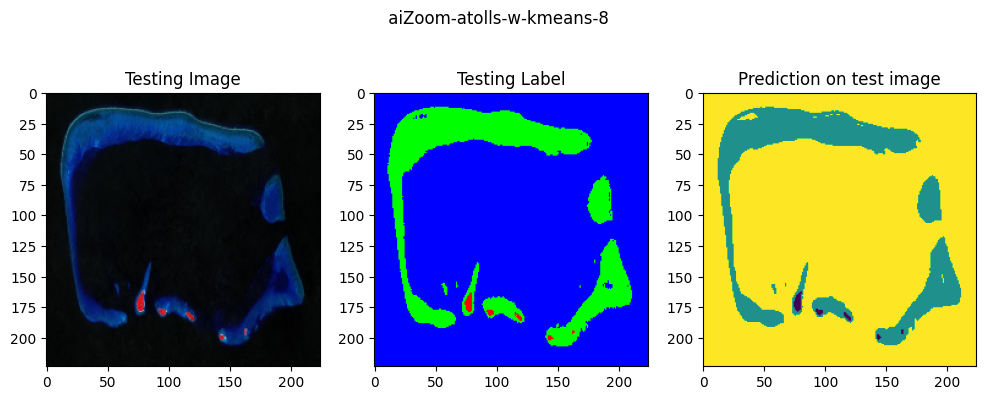

1/1 [==============================] - 0s 21ms/step


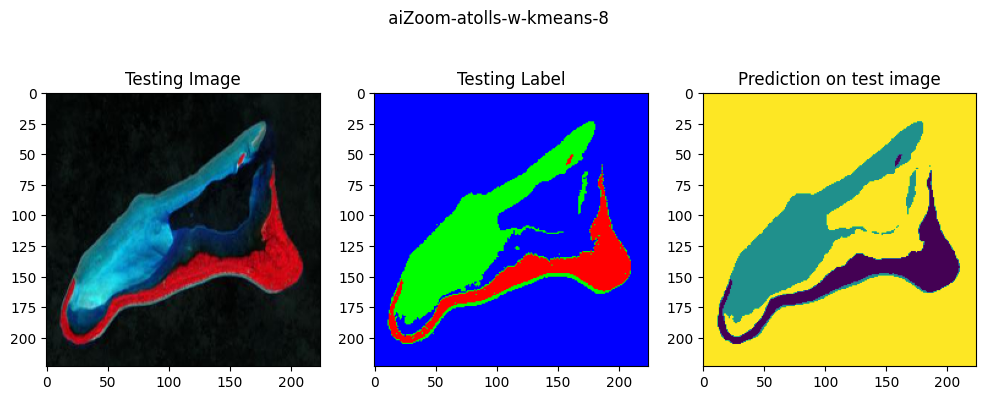

1/1 [==============================] - 0s 26ms/step


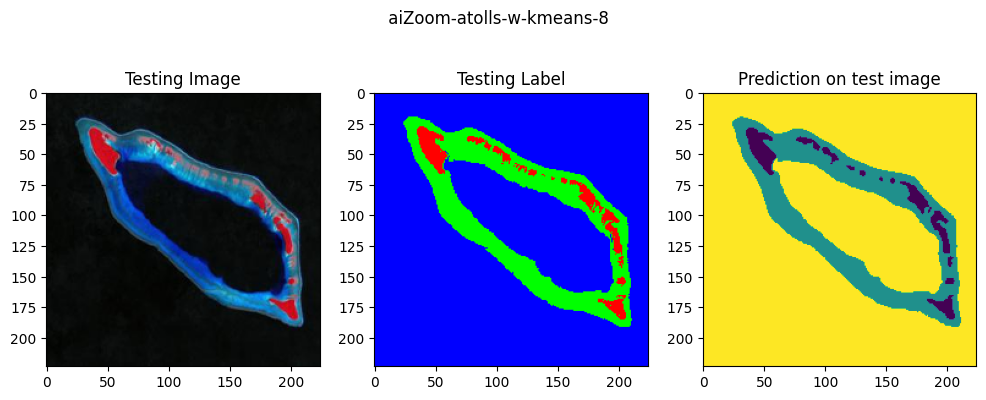

1/1 [==============================] - 0s 24ms/step


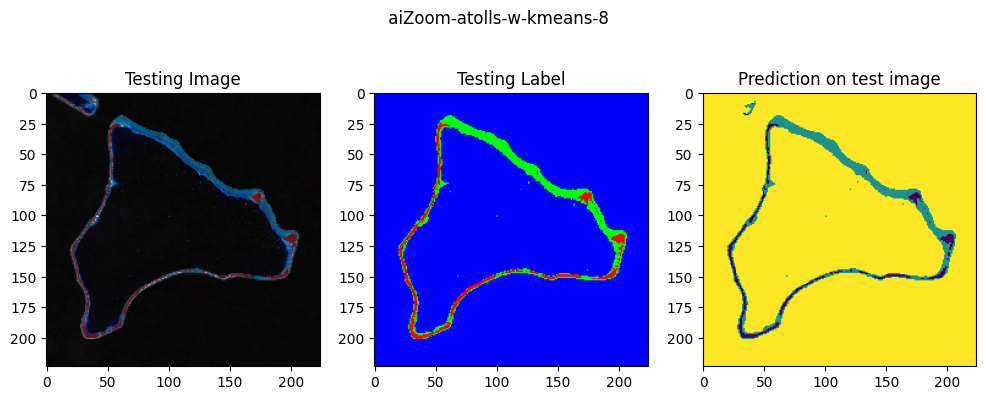

1/1 [==============================] - 0s 19ms/step


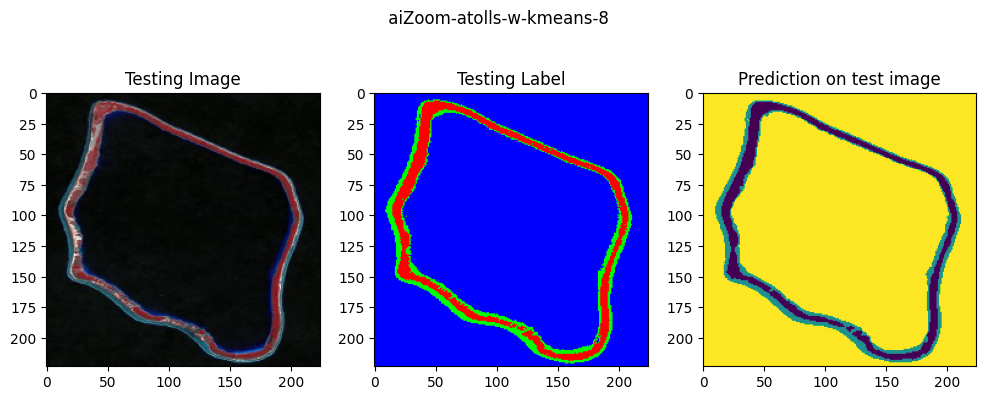

1/1 [==============================] - 0s 21ms/step


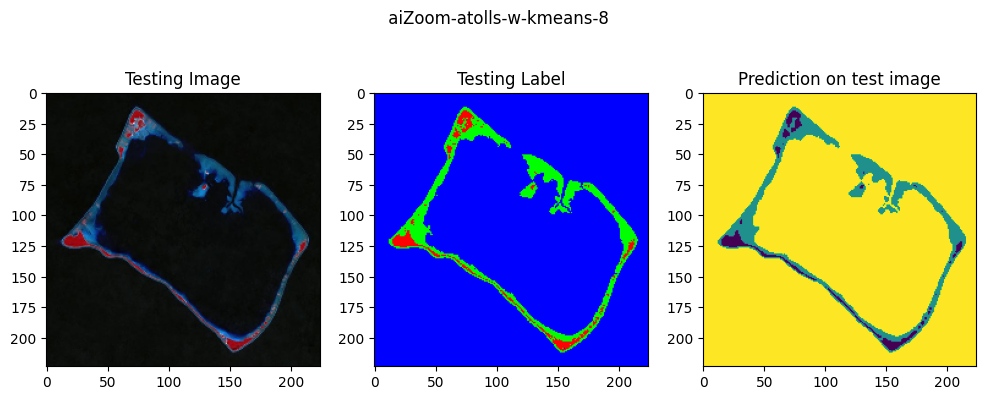

1/1 [==============================] - 0s 24ms/step


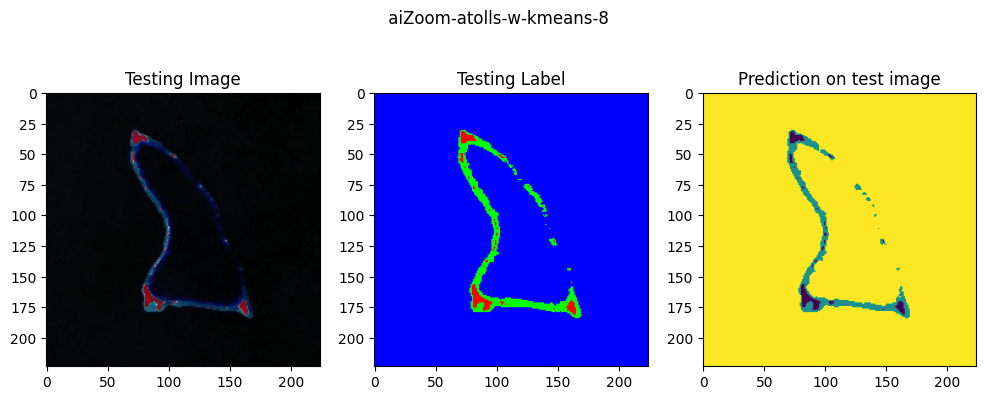

1/1 [==============================] - 0s 21ms/step


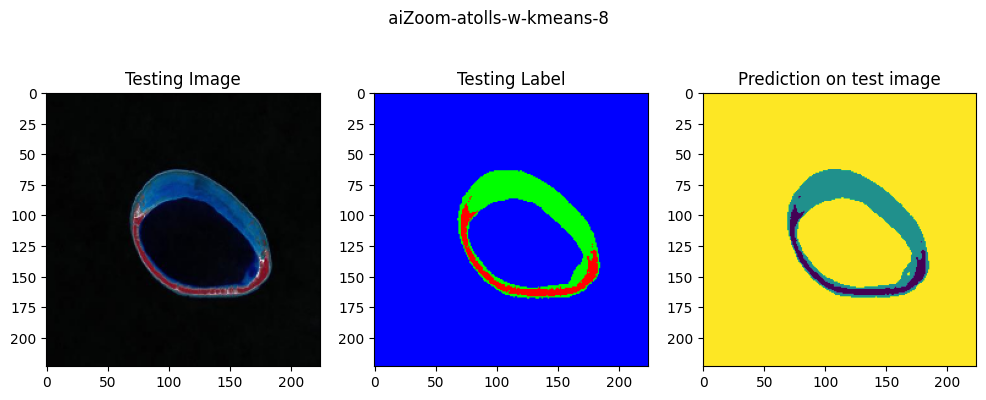

1/1 [==============================] - 0s 20ms/step


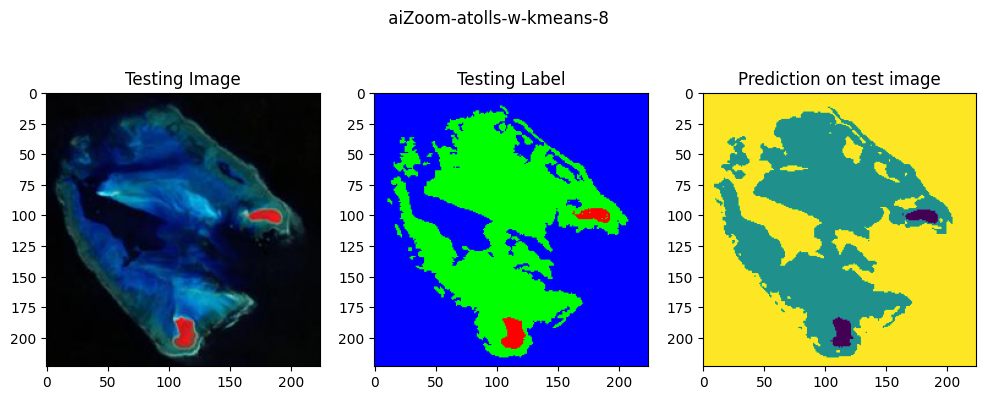

1/1 [==============================] - 0s 25ms/step


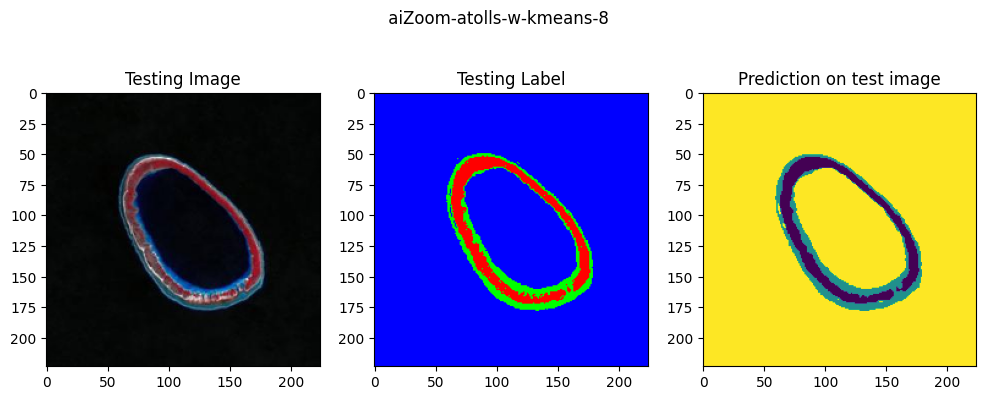

1/1 [==============================] - 0s 22ms/step


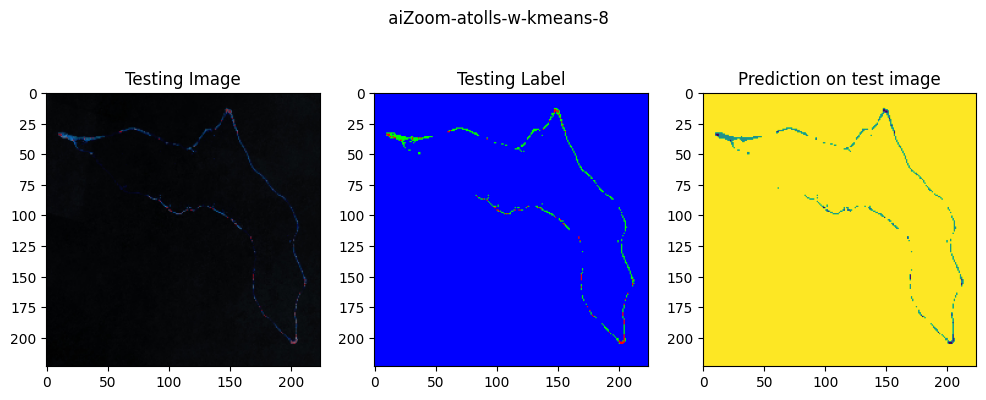

1/1 [==============================] - 0s 34ms/step


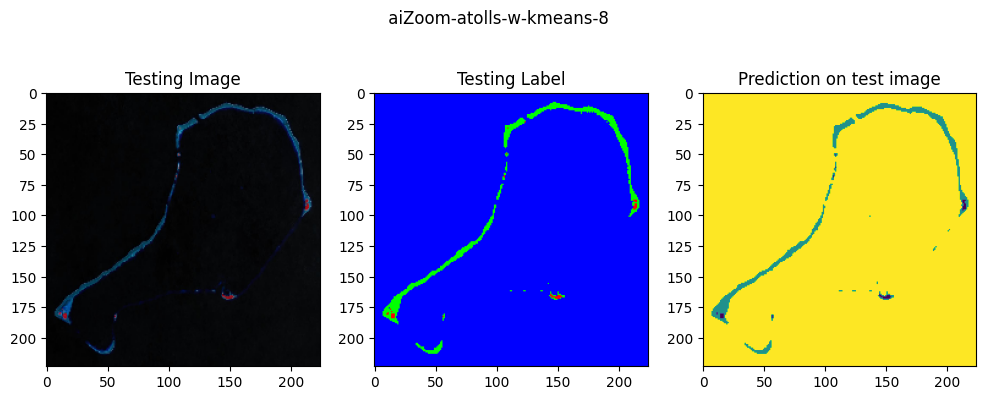

1/1 [==============================] - 0s 31ms/step


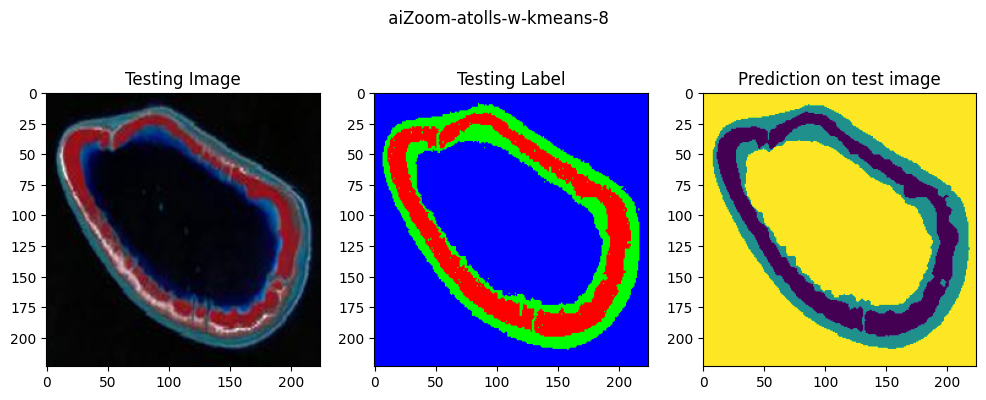

1/1 [==============================] - 0s 35ms/step


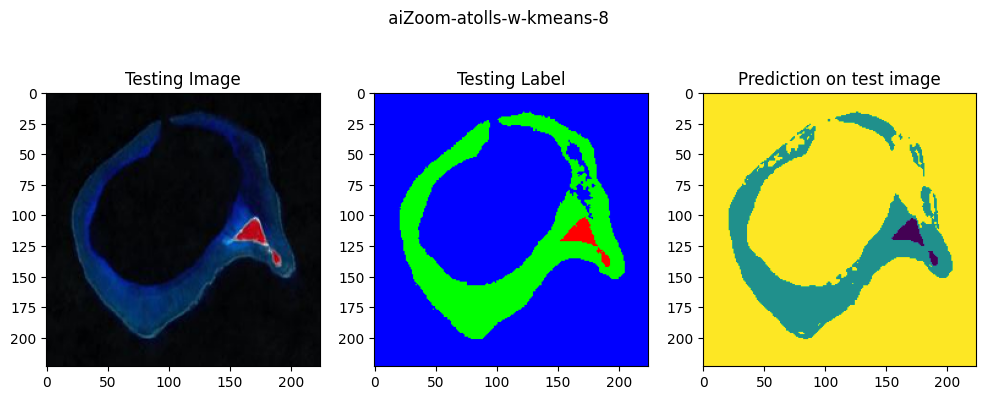

1/1 [==============================] - 0s 46ms/step


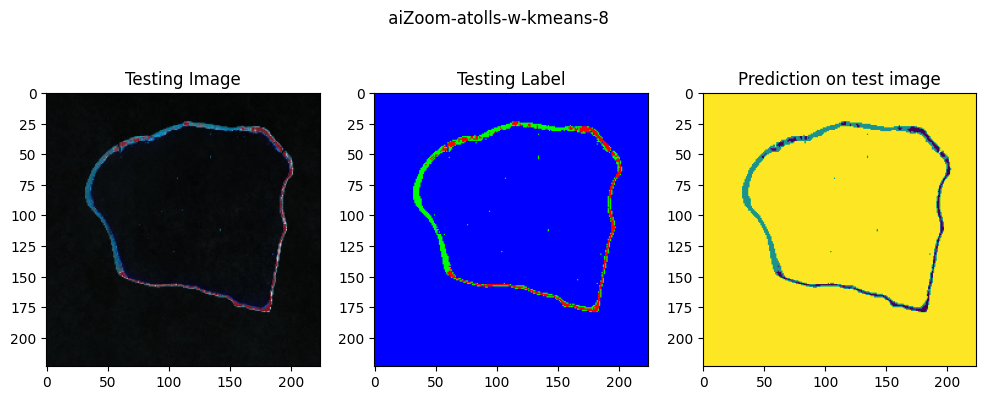

1/1 [==============================] - 0s 23ms/step


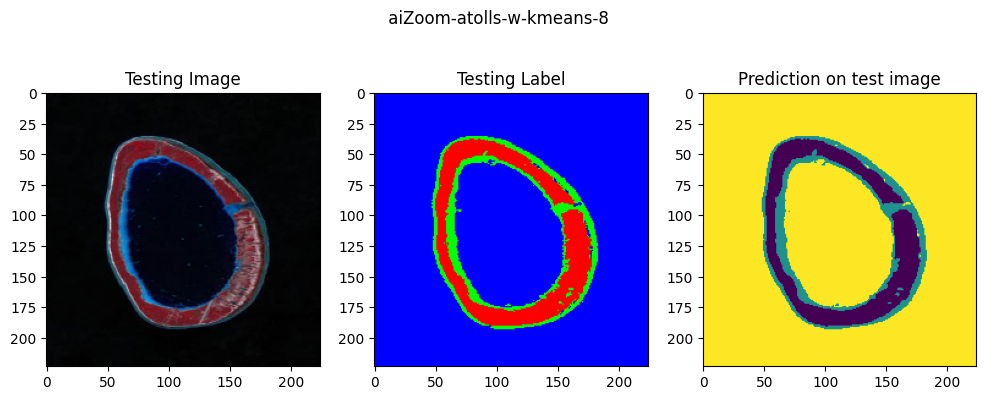

1/1 [==============================] - 0s 29ms/step


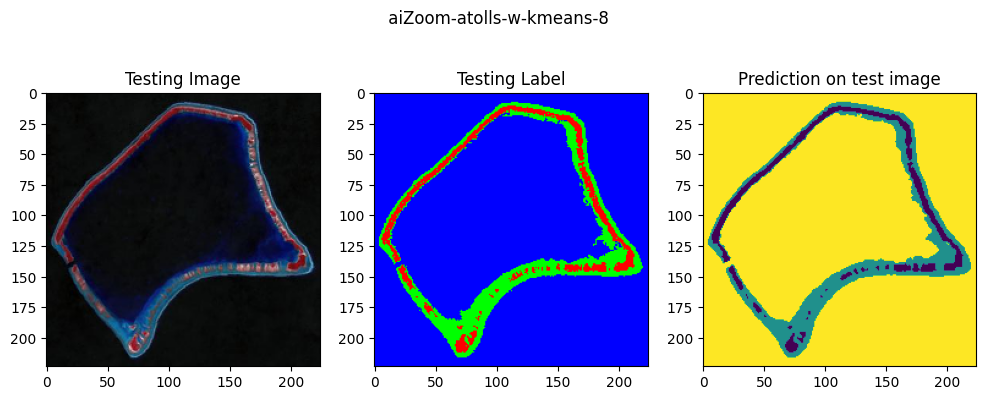

1/1 [==============================] - 0s 27ms/step


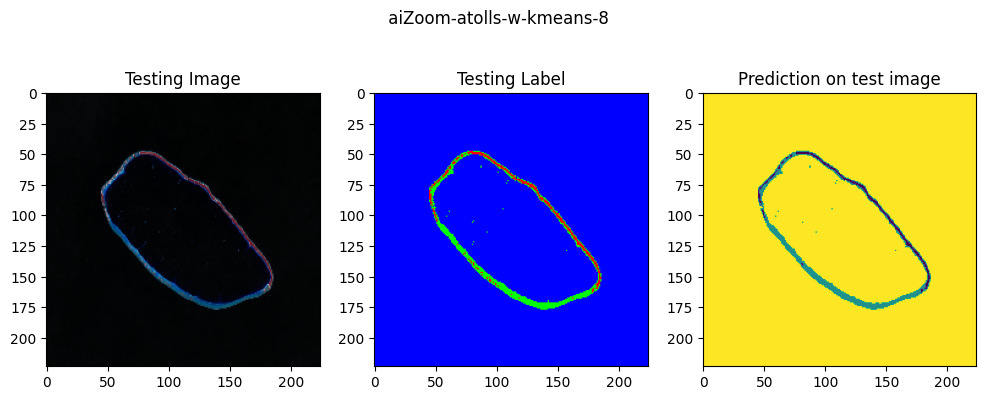

1/1 [==============================] - 0s 24ms/step


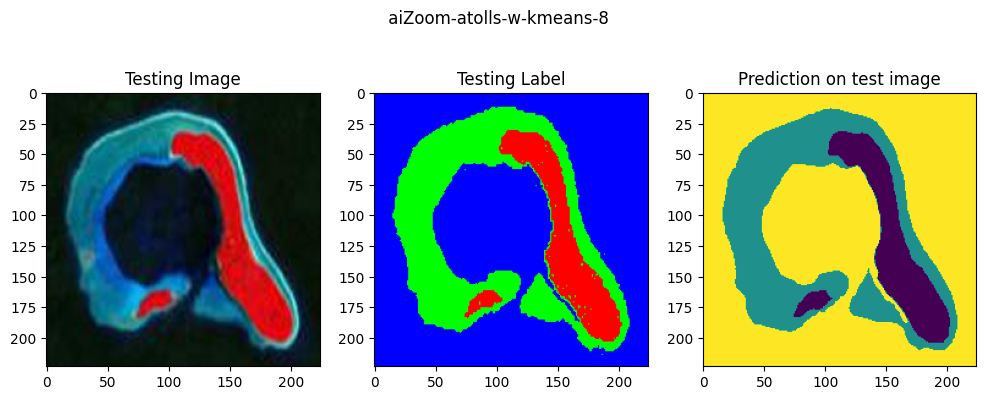

1/1 [==============================] - 0s 31ms/step


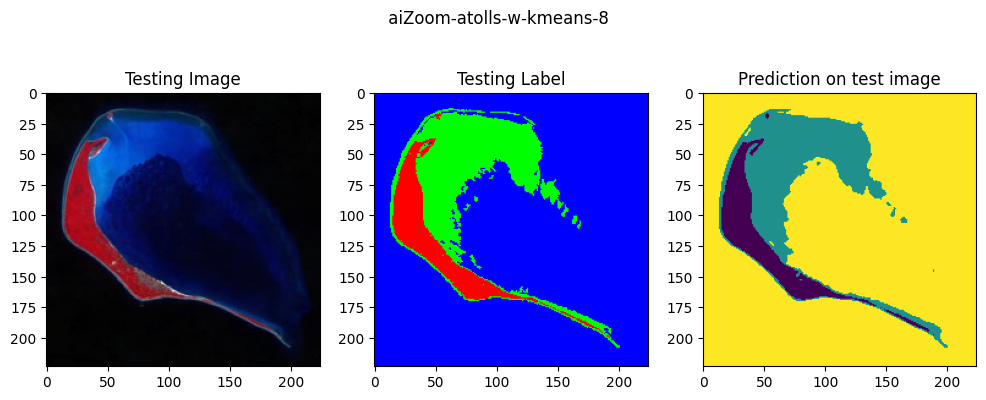

1/1 [==============================] - 0s 28ms/step


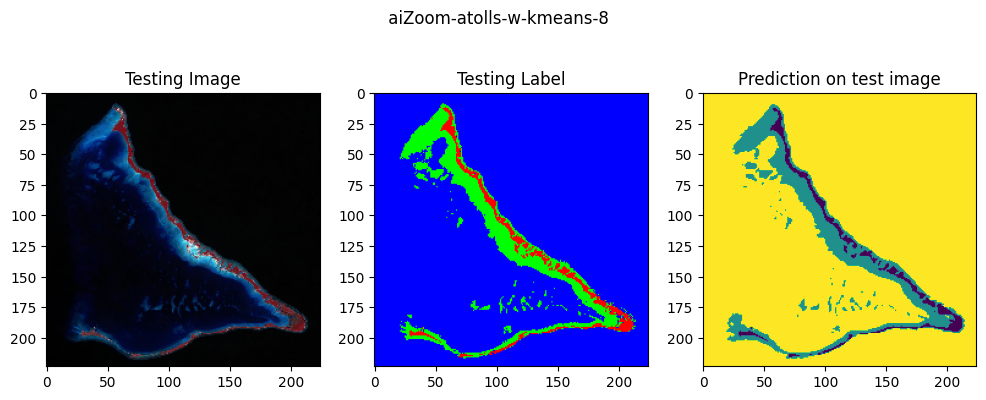

1/1 [==============================] - 0s 26ms/step


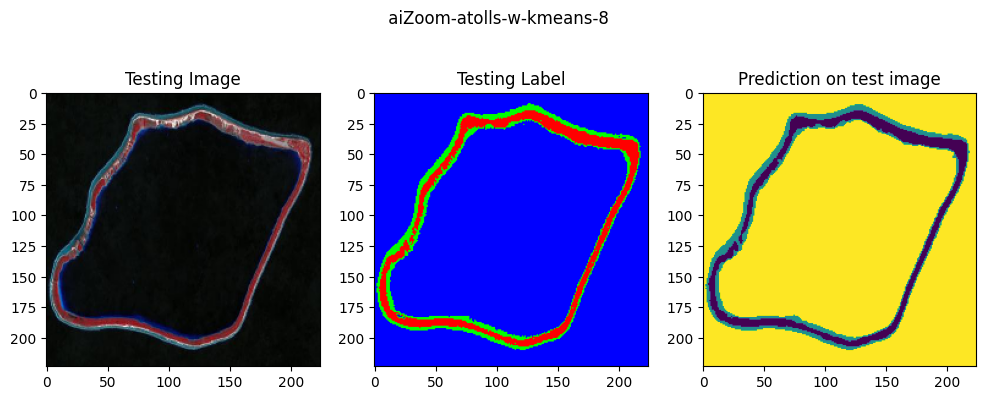

1/1 [==============================] - 0s 26ms/step


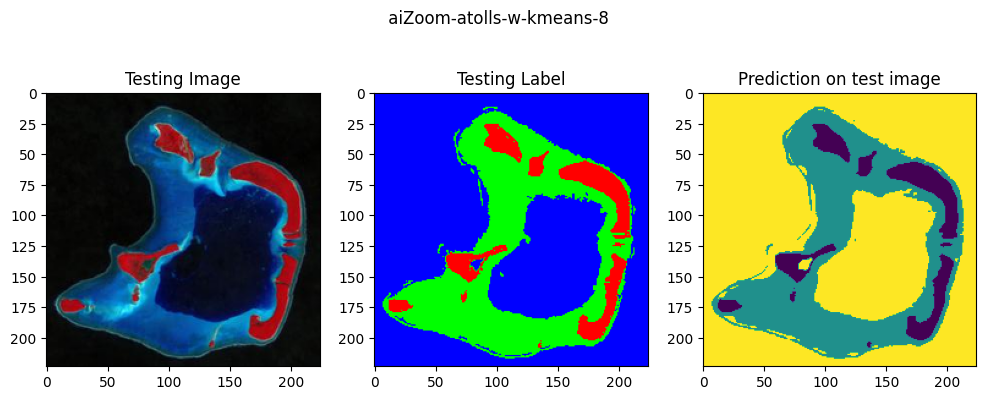

1/1 [==============================] - 0s 28ms/step


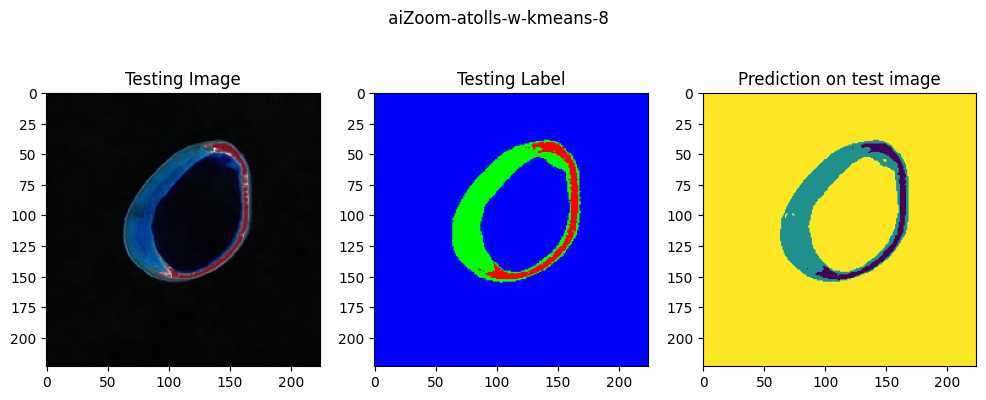

1/1 [==============================] - 0s 30ms/step


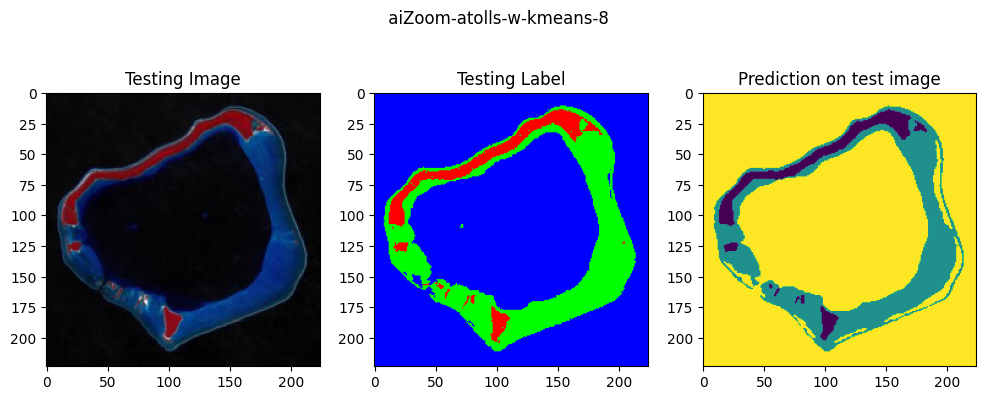

1/1 [==============================] - 0s 43ms/step


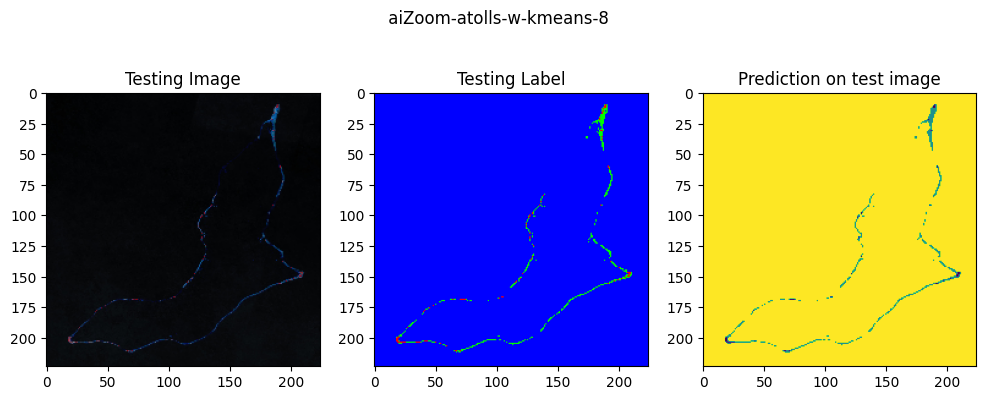

1/1 [==============================] - 0s 33ms/step


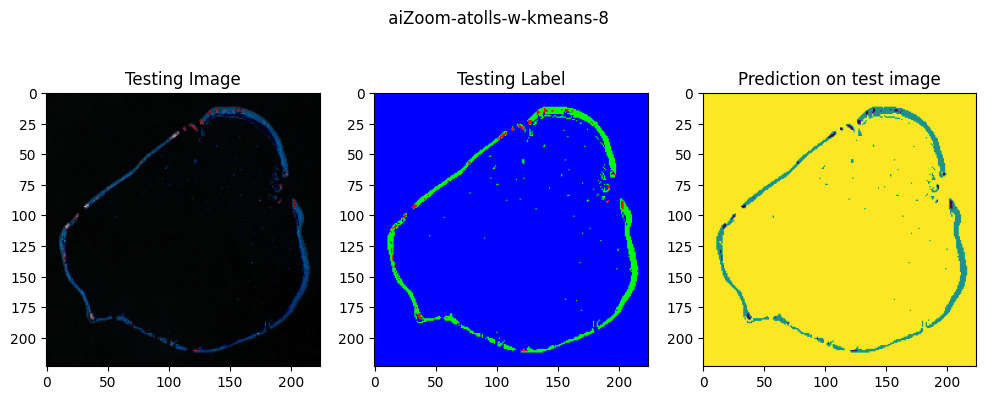

1/1 [==============================] - 0s 32ms/step


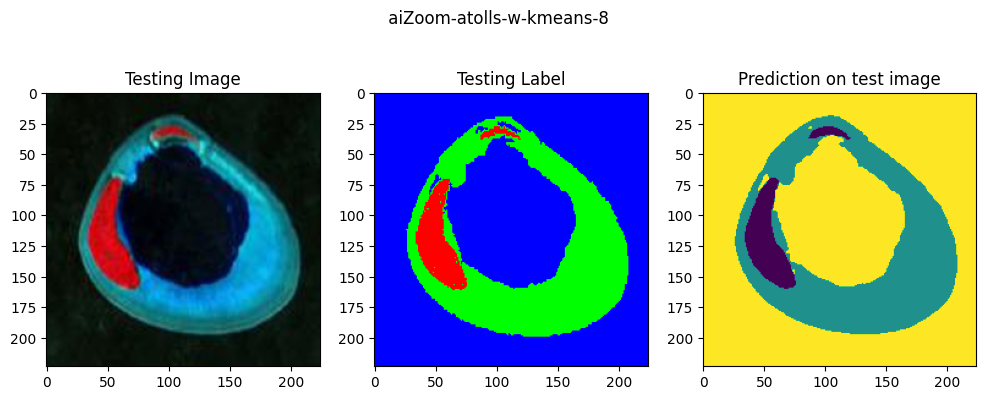

1/1 [==============================] - 0s 32ms/step


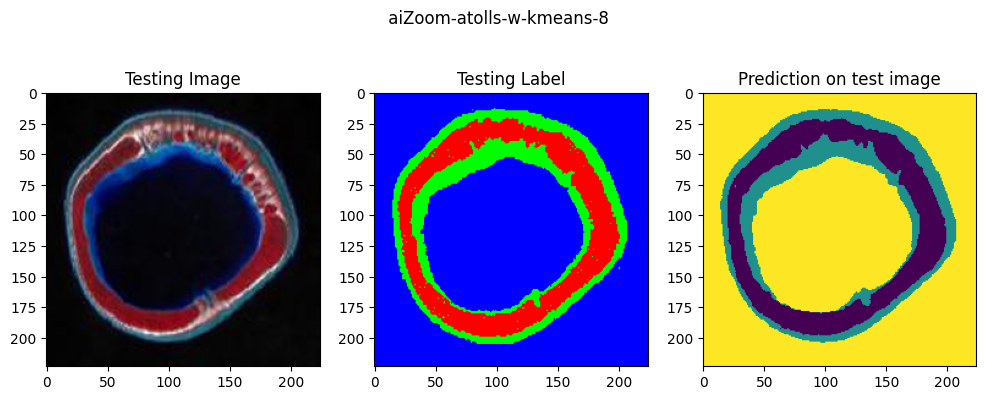

1/1 [==============================] - 0s 31ms/step


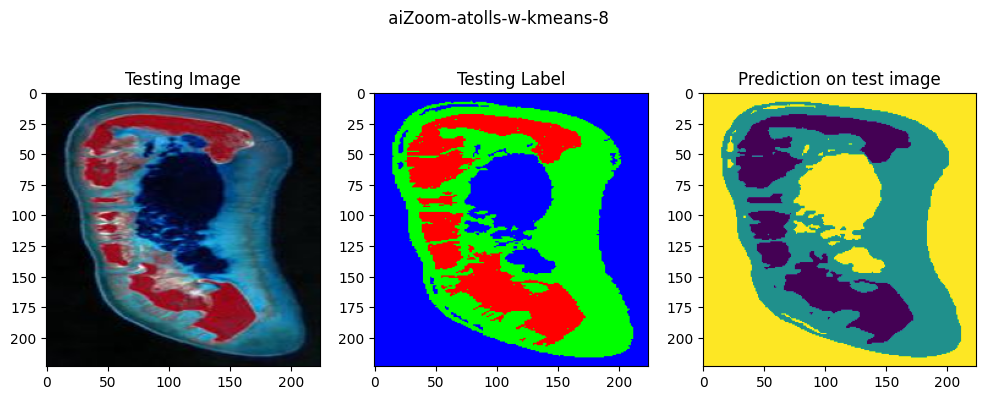

1/1 [==============================] - 0s 30ms/step


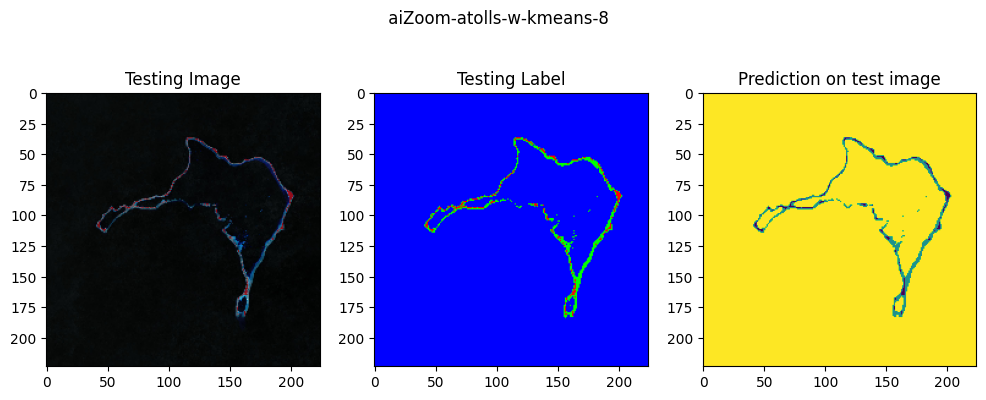

1/1 [==============================] - 0s 46ms/step


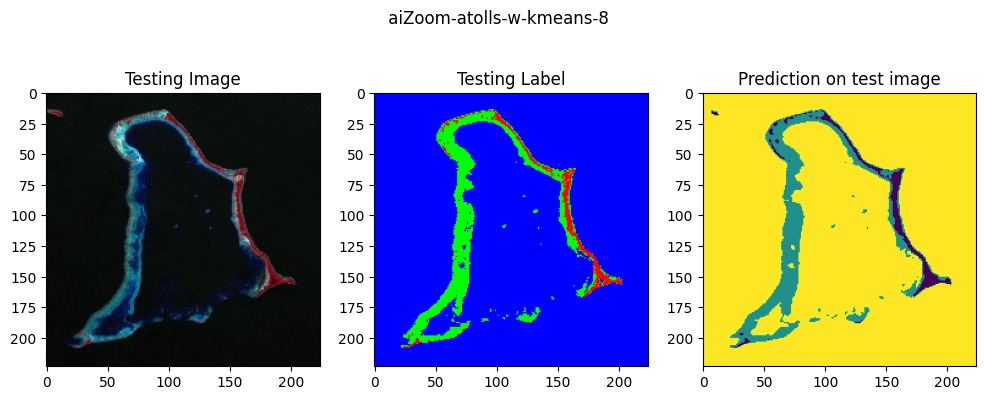

1/1 [==============================] - 0s 27ms/step


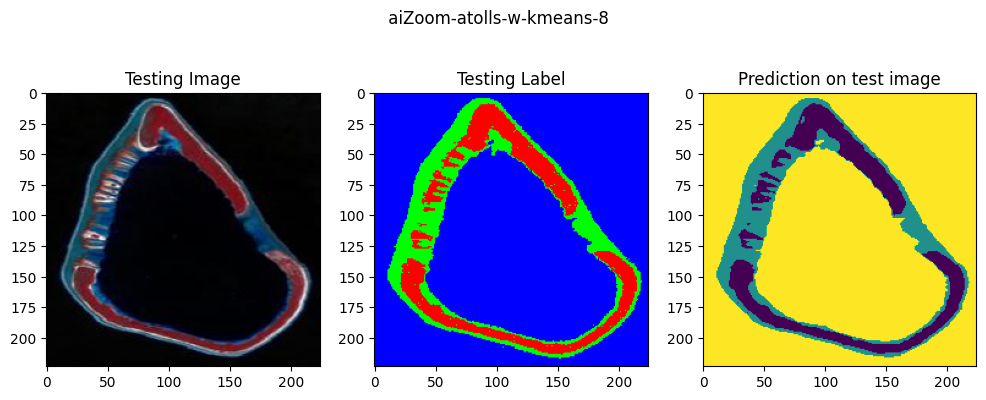

1/1 [==============================] - 0s 27ms/step


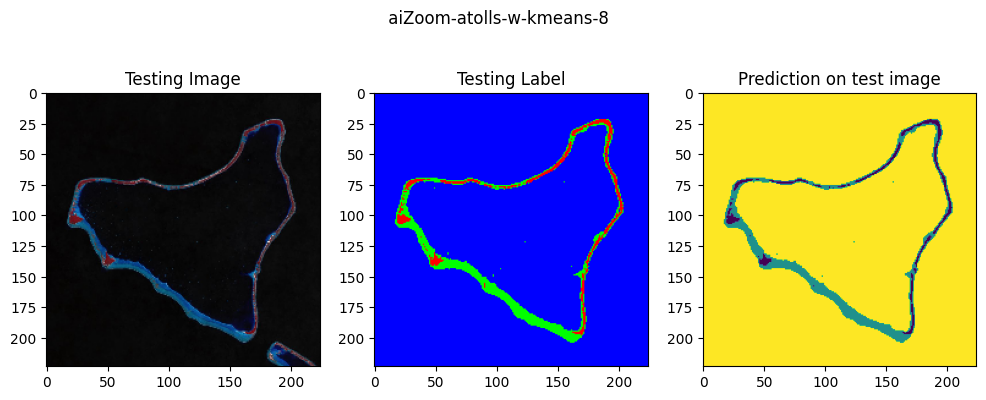

1/1 [==============================] - 0s 31ms/step


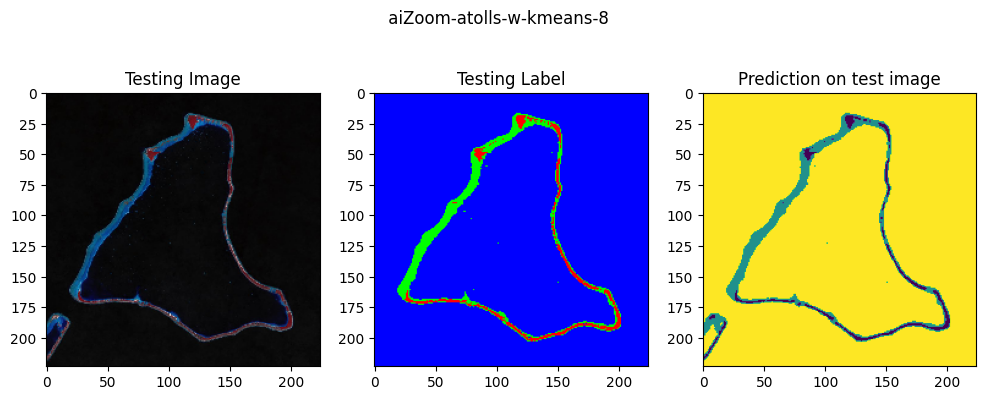

1/1 [==============================] - 0s 32ms/step


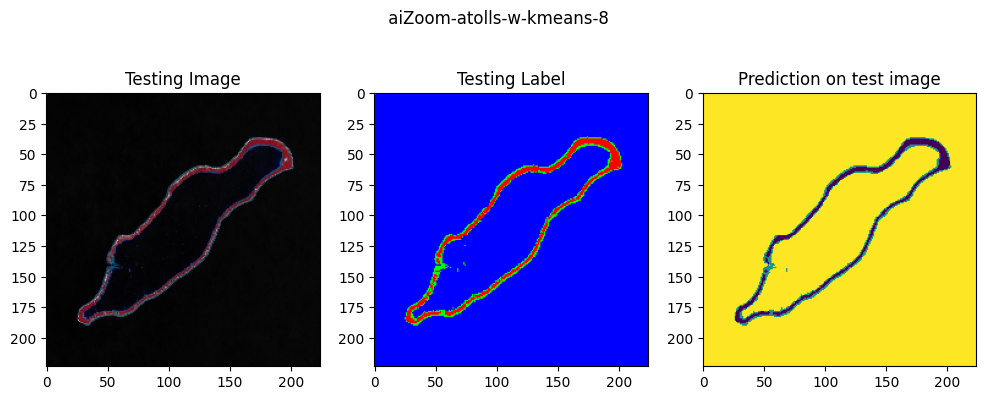

1/1 [==============================] - 0s 29ms/step


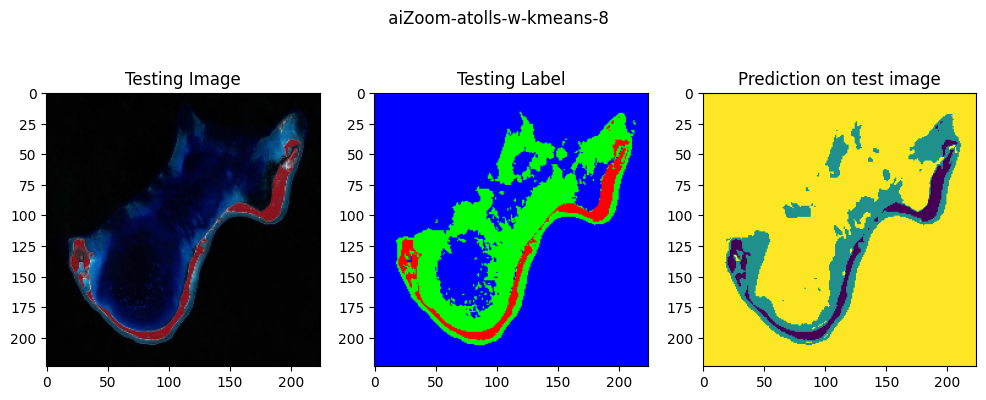

1/1 [==============================] - 0s 29ms/step


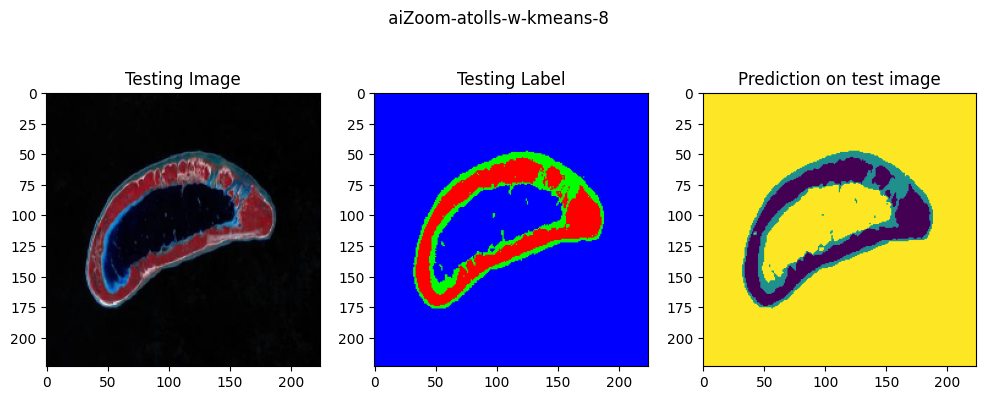

1/1 [==============================] - 0s 29ms/step


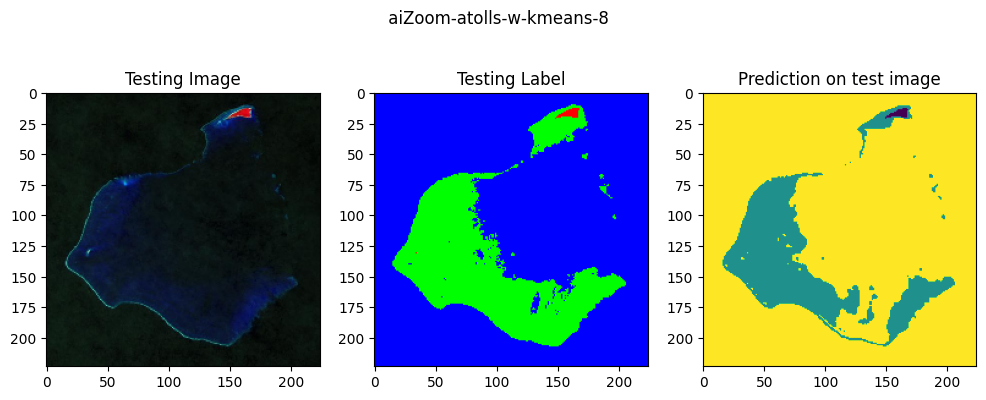

1/1 [==============================] - 0s 34ms/step


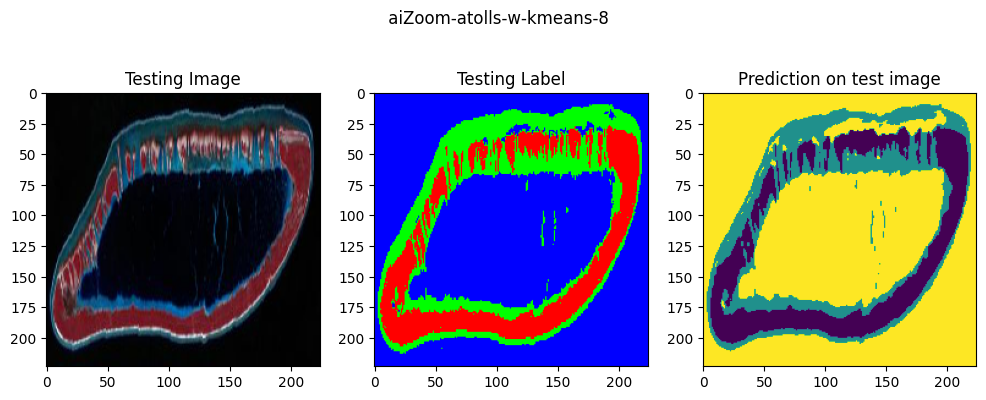

1/1 [==============================] - 0s 30ms/step


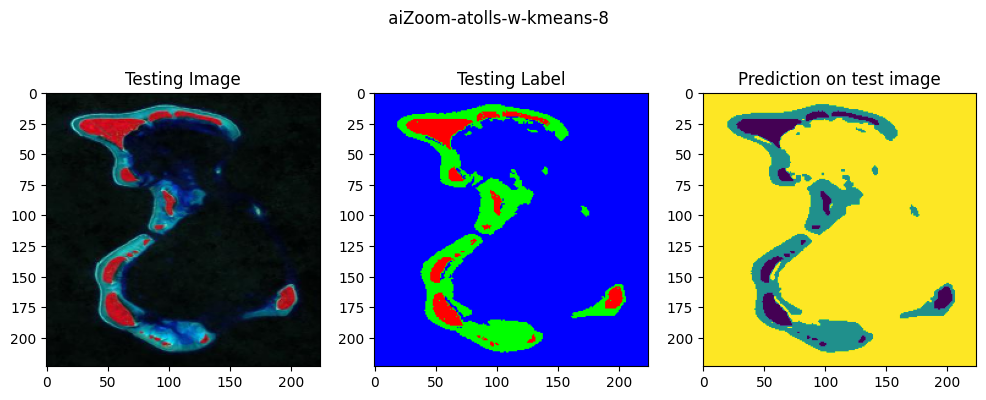

1/1 [==============================] - 0s 28ms/step


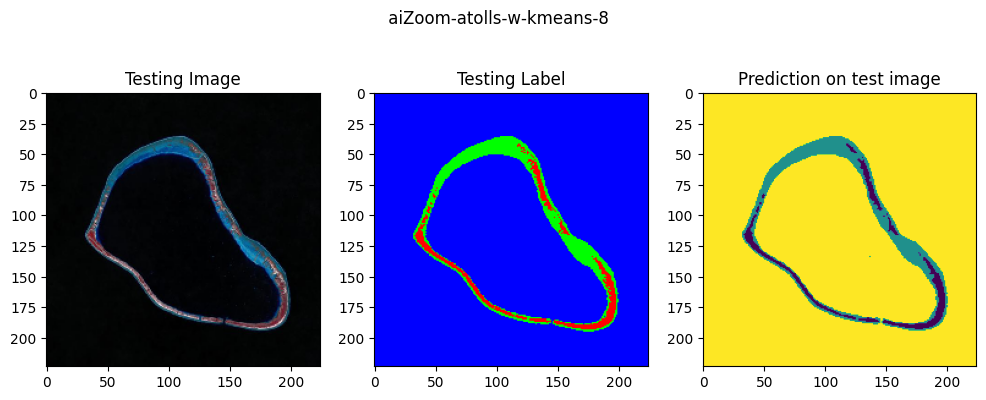

1/1 [==============================] - 0s 27ms/step


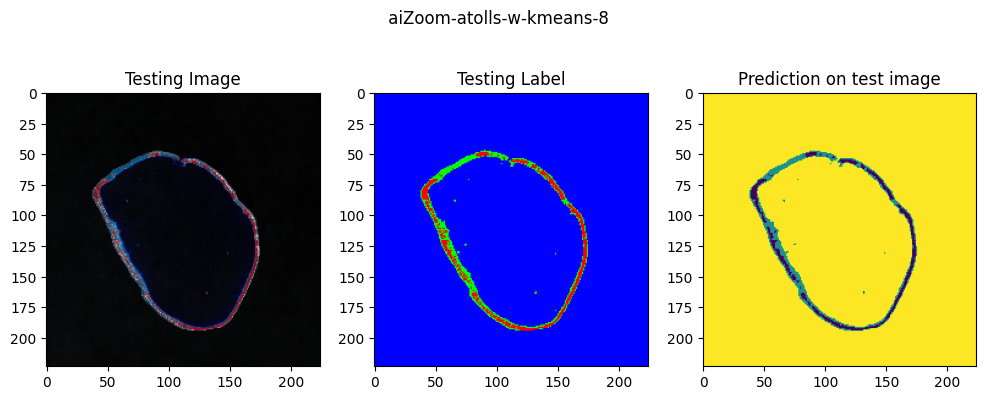

1/1 [==============================] - 0s 30ms/step


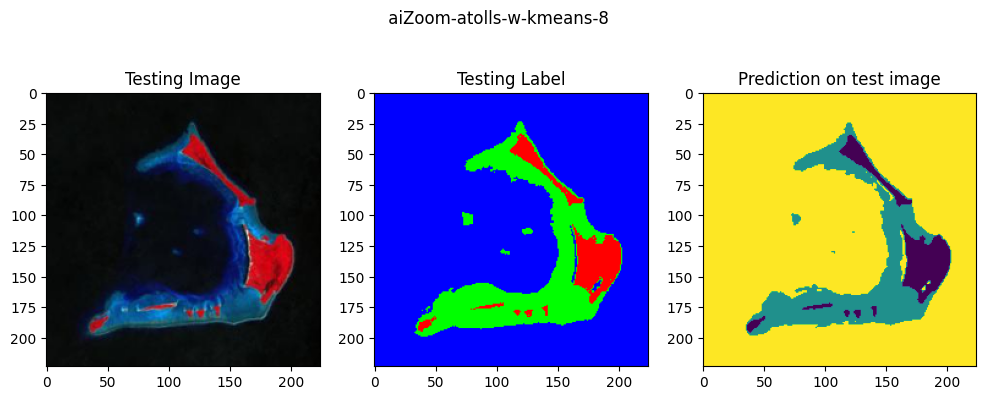

1/1 [==============================] - 0s 34ms/step


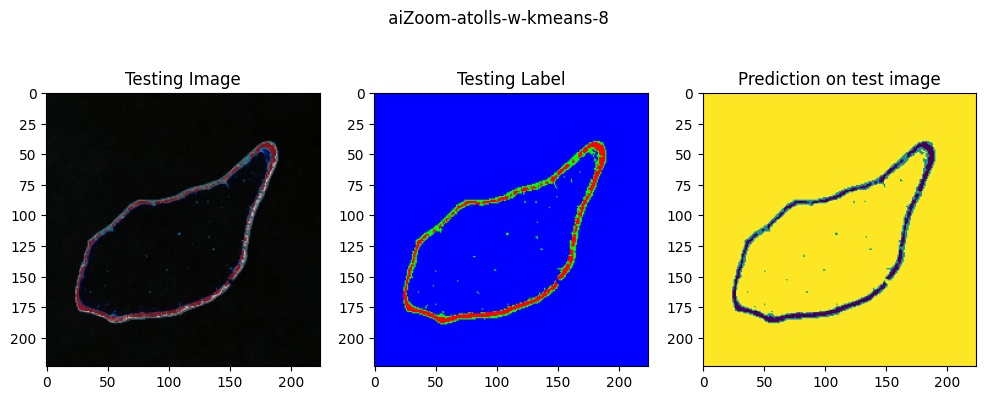

1/1 [==============================] - 0s 30ms/step


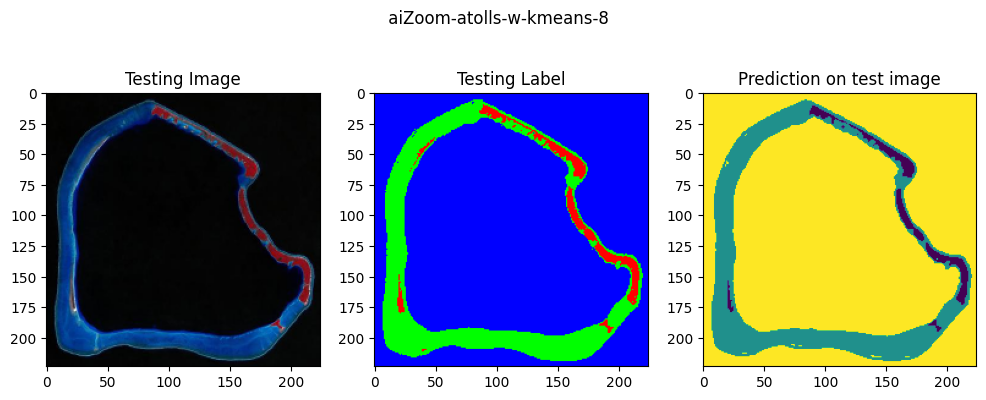

1/1 [==============================] - 0s 31ms/step


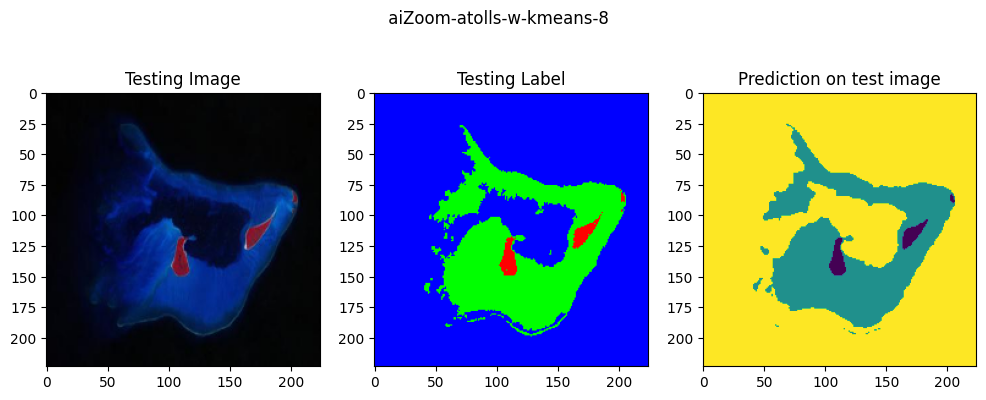

1/1 [==============================] - 0s 36ms/step


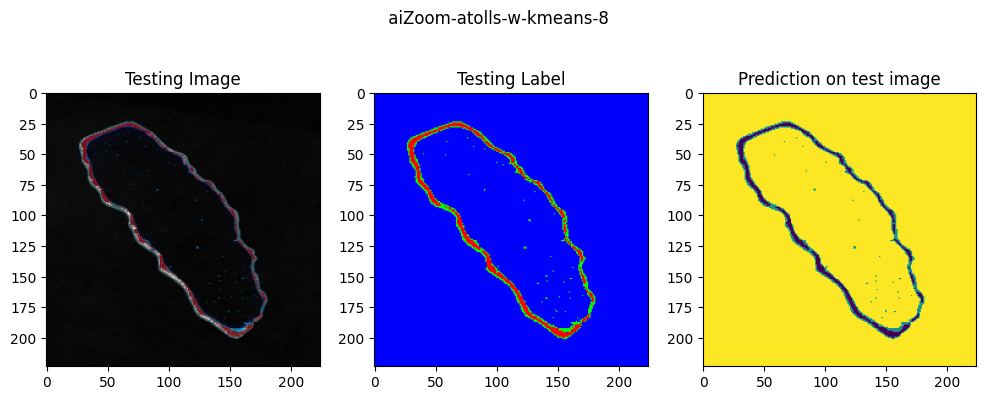

1/1 [==============================] - 0s 28ms/step


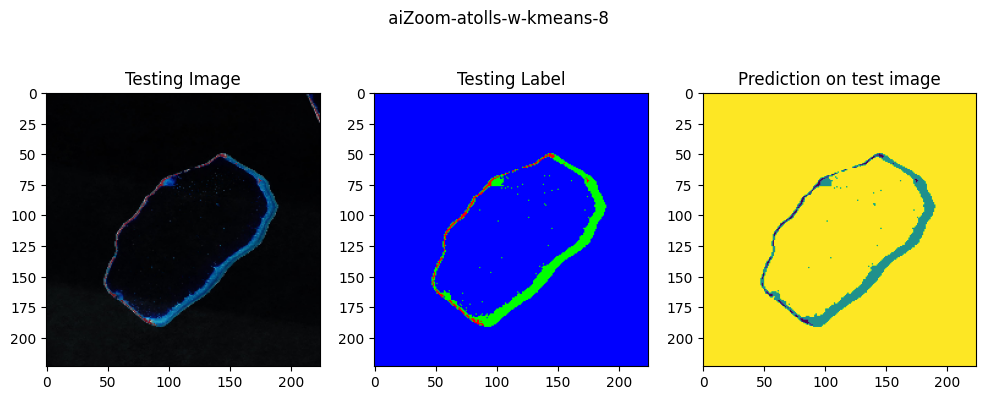

1/1 [==============================] - 0s 29ms/step


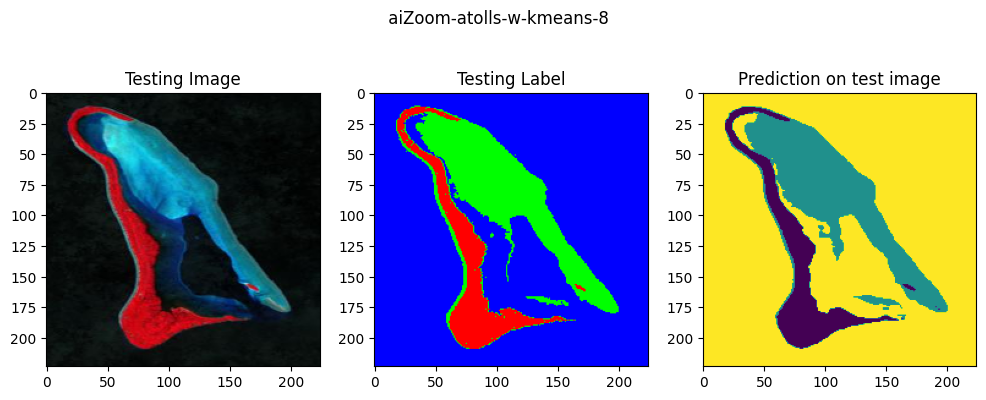

1/1 [==============================] - 0s 37ms/step


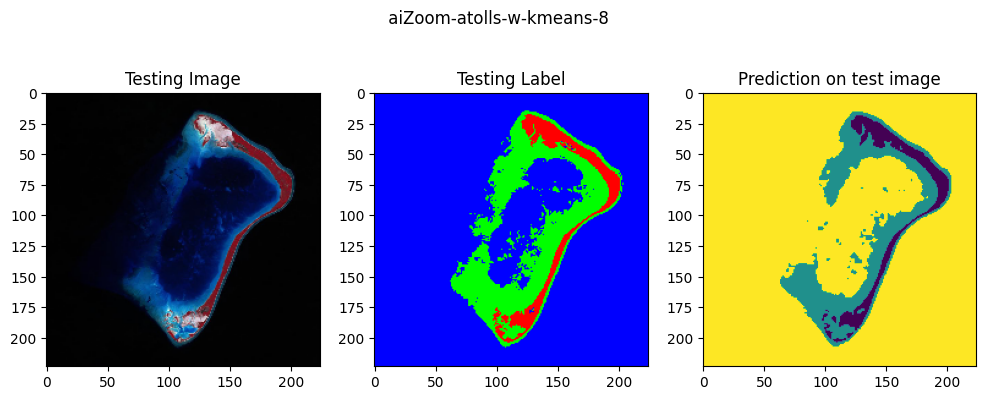

1/1 [==============================] - 0s 34ms/step


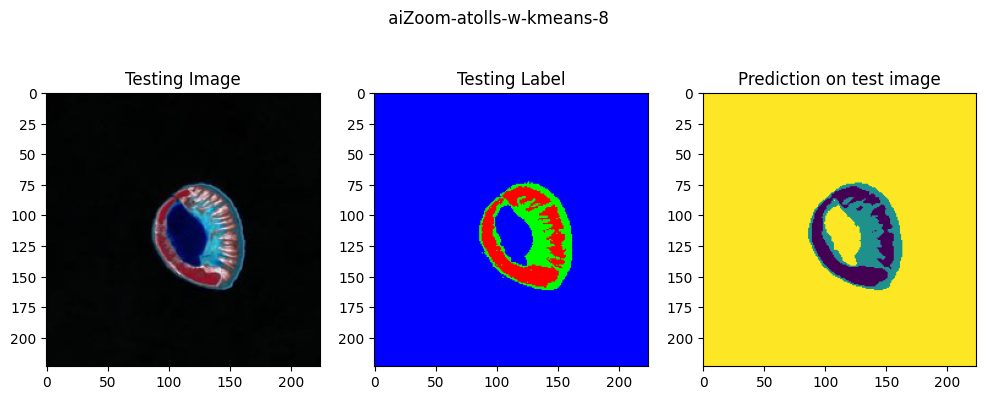

1/1 [==============================] - 0s 35ms/step


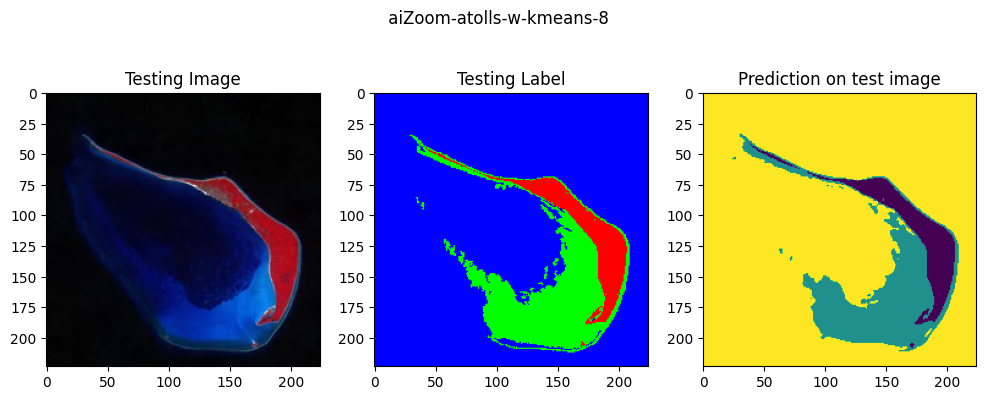

1/1 [==============================] - 0s 41ms/step


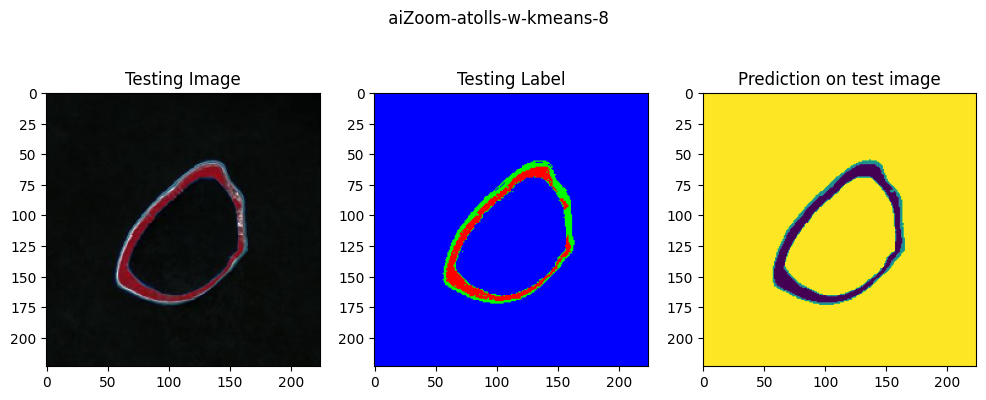

1/1 [==============================] - 0s 35ms/step


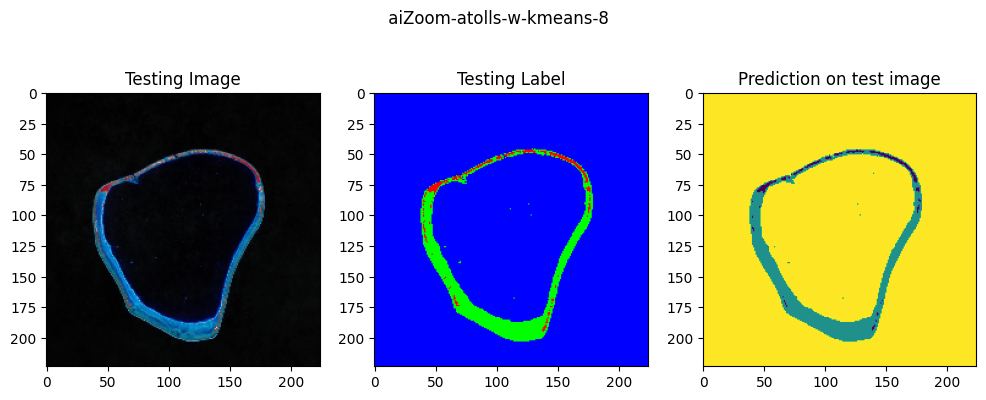

1/1 [==============================] - 0s 31ms/step


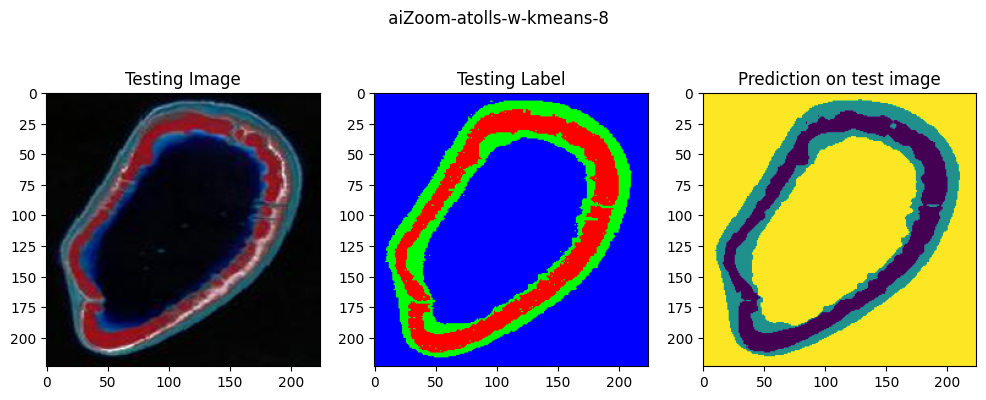

1/1 [==============================] - 0s 35ms/step


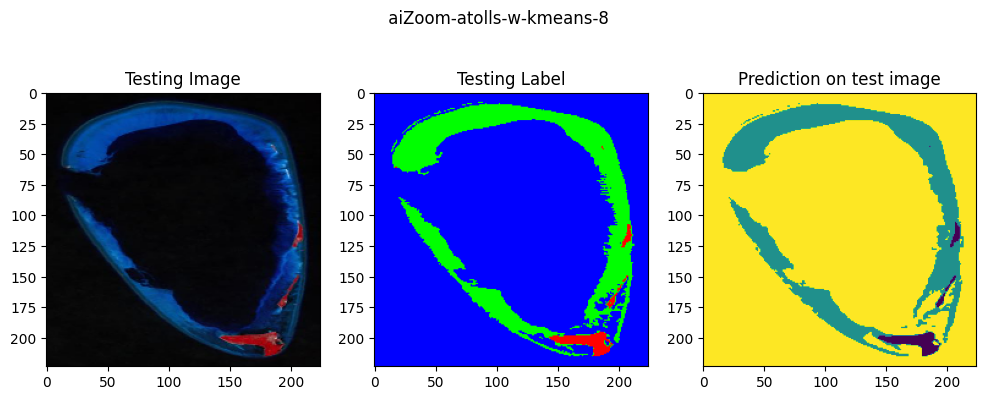

1/1 [==============================] - 0s 27ms/step


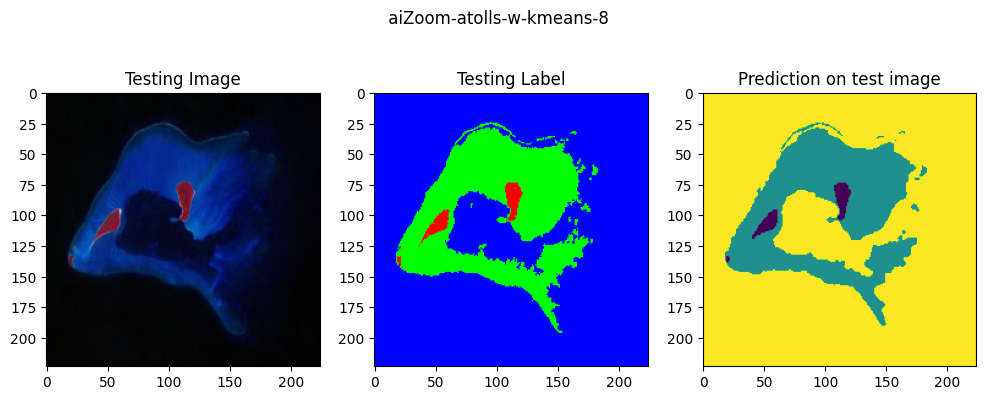

In [16]:
for i in range(X_test.shape[0]):
  test_img = X_test[i]
  ground_truth=y_test[i]
  test_img_norm=test_img[:,:,0][:,:,None]
  four_dim = np.expand_dims(test_img, axis = 0)

  prediction = (model.predict(four_dim))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  plt.figure(figsize=(12, 8))

  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img.astype(np.uint8), cmap='viridis')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow((255*ground_truth).astype(np.uint8), cmap='viridis')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img.astype(np.uint8), cmap='viridis')
  plt.suptitle(" aiZoom-atolls-w-kmeans-8")
  # #uncomment to save figures
  # fig = plt.gcf()
  # num = random.randint(0,100)
  # plt.savefig("/content/drive/MyDrive/Coral_Reef_Metadata/SavedFigs/aiZoom-atolls-w-kmeans-8-"+str(num))
  plt.show()